In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load data in chunks to handle large file size
chunk_size = 500000  # Adjust chunk size for memory efficiency
chunks = []

# Reading the dataset in chunks
for chunk in pd.read_csv(r'C:/Users/User/Desktop/MDT 28/Assignments/Microsoft -Classifying Cybersecurity Incidents/GUIDE_Train.csv/GUIDE_Train.csv', chunksize=chunk_size, low_memory=False):
    # Optimize memory usage by downcasting data types
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free up memory

In [3]:
# spread of target value
df['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

In [6]:
df.duplicated().sum()

np.int64(22559)

In [4]:
# Remove duplicate rows
df = df.drop_duplicates()

In [5]:
df.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5459368
IncidentGrade           51322
ActionGrouped         9438232
ActionGranular        9438232
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9397469
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9420765
FileName                    0
FolderPath

In [5]:
def data_cleaning(data):
    total_rows = data.shape[0]
    total_cols = data.shape[1]
    
    # Calculate the percentage of missing values in each column
    null_col = (data.isnull().sum(axis=0) / total_rows) * 100
    
    # Find columns with 55% or more missing values
    high_missing_cols = null_col[null_col >= 55].index.tolist()
    
    # Return appropriate messages
    if len(high_missing_cols) > 0:
        return "ATTENTION, there are missing values in the following column(s):", high_missing_cols
    else:
        return "No missing values found", []



In [6]:
# Example usage
missing_cols_message, missing_cols_list = data_cleaning(df)
print(missing_cols_message, missing_cols_list)

ATTENTION, there are missing values in the following column(s): ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [7]:
df = df.dropna(subset='IncidentGrade')

In [8]:
for each_col in missing_cols_list:
    df = df.drop(columns=each_col)


In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek


# Drop Timestamp column
df.drop(columns=['Timestamp'], inplace=True)

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole'], dtype='object')

In [11]:
# creating list of numeric columns
# Create a list of all column names in the DataFrame
all_columns = df.columns.tolist()

# Create a new list with columns except the excluded ones
numeric_columns = [col for col in all_columns if col not in categorical_columns]

In [12]:
# Dictionary to store the encoders for each column
encoders = {}

# Encode the categorical columns and save the encoders
for column in categorical_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

# Save the encoders dictionary to a pickle file
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(encoders, file)

print("Encoders have been saved.")

Encoders have been saved.


In [13]:
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']
del df

In [14]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [15]:
df = pd.concat([X_resampled, y_resampled], axis=1)
del X,y

In [16]:
df['IncidentGrade'].value_counts()

IncidentGrade
0    2029564
1    2029564
2    2029564
Name: count, dtype: int64

In [ ]:
# Function to undersample
def undersample(df, class_column, class_value, n_samples):
    class_data = df[df[class_column] == class_value]
    class_data_sampled = class_data.sample(n=n_samples, random_state=42)
    return class_data_sampled

# Undersampling each class to 1,500,000 instances
n_samples = 1500000
under_benign = undersample(df, 'IncidentGrade', 'BenignPositive', n_samples)
under_true = undersample(df, 'IncidentGrade', 'TruePositive', n_samples)
under_false = undersample(df, 'IncidentGrade', 'FalsePositive', n_samples)

# Concatenating the undersampled data
undersampled_df = pd.concat([under_benign, under_true, under_false])

undersampled_df['IncidentGrade'].value_counts()
del df


np.int64(132714)

In [17]:
# Initialize a dictionary to store p-values
chi2_pvalues = {}
selected_cat_feature = []

# Loop over each categorical column
for col in categorical_columns:
    # Create contingency table for 'IncidentGrade' vs the current column
    contingency_table = pd.crosstab(df['IncidentGrade'], df[col])
    
    # Perform Chi-Square test to check for independence
    _, p, _, _ = stats.chi2_contingency(contingency_table)
    
    # Store the p-value in the dictionary
    chi2_pvalues[col] = p

# Print the p-values and select features with p-values < 0.05
for col, p_value in chi2_pvalues.items():
    if p_value < 0.05:
        print(f'P-value for IncidentGrade vs {col}: {p_value}')
        selected_cat_feature.append(col)

# List of selected categorical features with significant p-values
print("Selected Categorical Features:", selected_cat_feature)


P-value for IncidentGrade vs Category: 0.0
P-value for IncidentGrade vs IncidentGrade: 0.0
P-value for IncidentGrade vs EntityType: 0.0
P-value for IncidentGrade vs EvidenceRole: 0.0
Selected Categorical Features: ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']


In [18]:
# Dictionary to store ANOVA p-values
anova_pvalues = {}
selected_numeric_features = []

# Loop over each numeric column and perform ANOVA
for each_col in numeric_columns:
    try:
        # Perform ANOVA for each numeric column
        groups = [df[each_col][df['IncidentGrade'] == category] for category in df['IncidentGrade'].unique()]
        _, anova_result = stats.f_oneway(*groups)
        
        # Store the p-value in the dictionary
        anova_pvalues[each_col] = anova_result
    except:
        continue

# Filter p-values below 0.05
significant_anova_pvalues = {k: v for k, v in anova_pvalues.items() if v < 0.05}

# Sort the significant p-values in ascending order and select top 10
sorted_significant_anova_pvalues = {k: v for k, v in sorted(significant_anova_pvalues.items(), key=lambda item: item[1])}
top_7_features = list(sorted_significant_anova_pvalues.keys())[:10]

# Print the sorted significant p-values and append to selected_numeric_features
for category, pvalue in sorted_significant_anova_pvalues.items():
    print(f'PValue for {category} : {pvalue}')
    if category in top_7_features:
        selected_numeric_features.append(category)

print("Selected Numeric Features:", selected_numeric_features)


PValue for Id : 0.0
PValue for OrgId : 0.0
PValue for IncidentId : 0.0
PValue for AlertId : 0.0
PValue for DetectorId : 0.0
PValue for AlertTitle : 0.0
PValue for DeviceId : 0.0
PValue for Sha256 : 0.0
PValue for IpAddress : 0.0
PValue for Url : 0.0
PValue for AccountSid : 0.0
PValue for AccountUpn : 0.0
PValue for AccountObjectId : 0.0
PValue for AccountName : 0.0
PValue for DeviceName : 0.0
PValue for NetworkMessageId : 0.0
PValue for RegistryKey : 0.0
PValue for ApplicationId : 0.0
PValue for ApplicationName : 0.0
PValue for FileName : 0.0
PValue for FolderPath : 0.0
PValue for ResourceIdName : 0.0
PValue for OSFamily : 0.0
PValue for OSVersion : 0.0
PValue for CountryCode : 0.0
PValue for State : 0.0
PValue for City : 0.0
PValue for month : 0.0
PValue for hour : 0.0
PValue for day_of_week : 0.0
PValue for RegistryValueData : 1.5903280833430016e-231
PValue for RegistryValueName : 4.343990674177357e-108
PValue for OAuthApplicationId : 8.110480434392107e-73
PValue for year : 8.6343193

In [19]:
selected_feature = selected_numeric_features + selected_cat_feature
selected_feature

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'DetectorId',
 'AlertTitle',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'Category',
 'IncidentGrade',
 'EntityType',
 'EvidenceRole']

In [20]:
df = df[selected_feature]

In [21]:
df.shape

(6088692, 14)

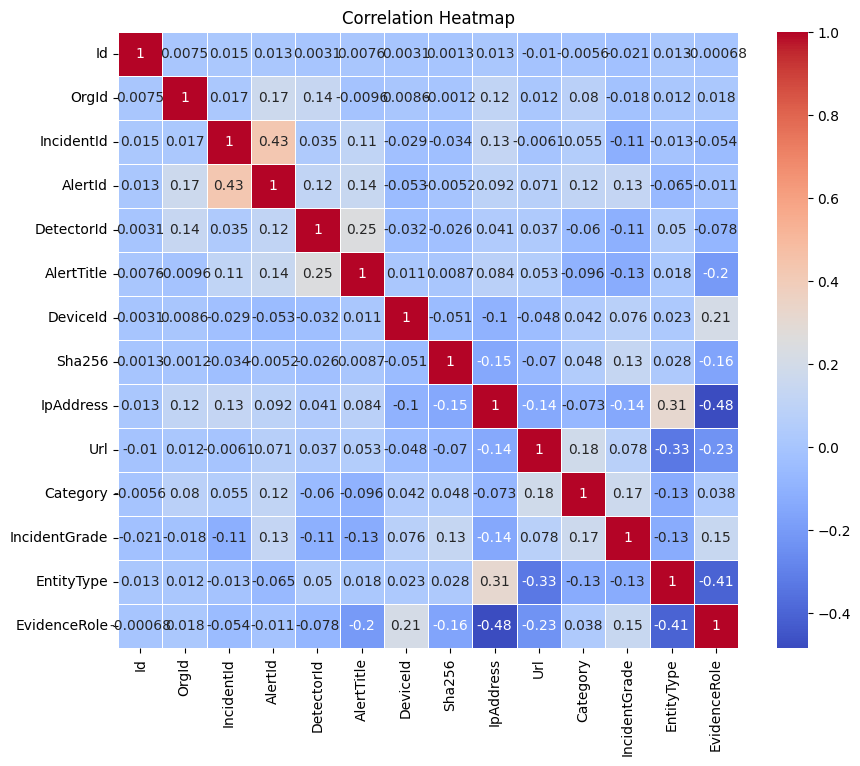

In [22]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [23]:
X = df.drop('IncidentGrade', axis = 1)
y = df['IncidentGrade']
del df

In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 43)

In [29]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors= 5, metric= "manhattan"),
    'XGB boosting': XGBClassifier(learning_rate= 0.06)
    }
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')  # Adjust for binary/multiclass
    f1 = f1_score(y_test, y_pred, average='macro')          # Adjust for binary/multiclass
    precision = precision_score(y_test, y_pred, average='macro')  # Adjust for binary/multiclass
    
    results[model_name] = {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'precision': precision
    }

for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print(f"Precision: {metrics['precision']}")
    print("\n")


Results for RandomForestClassifier:
Accuracy: 0.9833018405421852
Recall: 0.9833051457749477
F1 Score: 0.9833049582802396
Precision: 0.9833327662476036


Results for KNeighborsClassifier:
Accuracy: 0.8843003303663592
Recall: 0.8843133014982726
F1 Score: 0.8845223593229767
Precision: 0.8850586143765046


Results for XGB boosting:
Accuracy: 0.8252474462918573
Recall: 0.8252025446871847
F1 Score: 0.8263683838444944
Precision: 0.8364212091331655


